In [1]:
!pip install thop shapely --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requ

Using device: cuda
[EVAL] Loaded detector checkpoint from /kaggle/input/det-checkpoints-epoch50/det_point_yolo/best_detector.pth (epoch=47)


[Full Eval]:   0%|          | 0/21 [00:00<?, ?it/s]


  EVALUATION SUMMARY (FIXED)
  [Efficiency]
    Params (M): 0.03
    GMACs:      0.110362624
    FPS:        175.47

  [Geometric Errors (Tuned @ 0.5 IoU)]
    Samples (val):       657
    Positives (with GT): 0
    Class Acc (positives only): 0.000
    Center L2 (m):   0.000
    Size MAE (m):    0.000
    Yaw error (deg): 0.00
    AABB IoU (BEV):    0.000
    Oriented IoU (BEV): 0.000

  [mAP Metrics]
    TOTAL       : mAP@0.5=0.000  mAP@[.5:.95]=0.000
------------------------------
    FTS         : mAP@0.5=0.000  GTs=101  FPs=36716  FNs=0
    ELFplusplus : mAP@0.5=0.000  GTs=224  FPs=11152  FNs=0
    CargoBike   : mAP@0.5=0.000  GTs=259  FPs=19771  FNs=0
    Box         : mAP@0.5=0.000  GTs=609  FPs=113761  FNs=0
    ForkLift    : mAP@0.5=0.000  GTs=102  FPs=6100  FNs=0


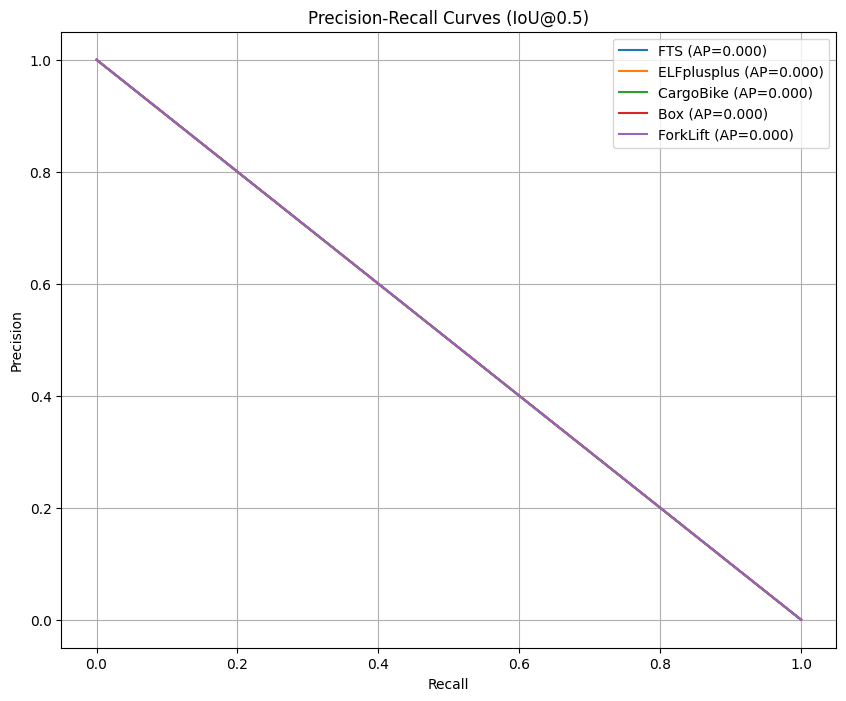

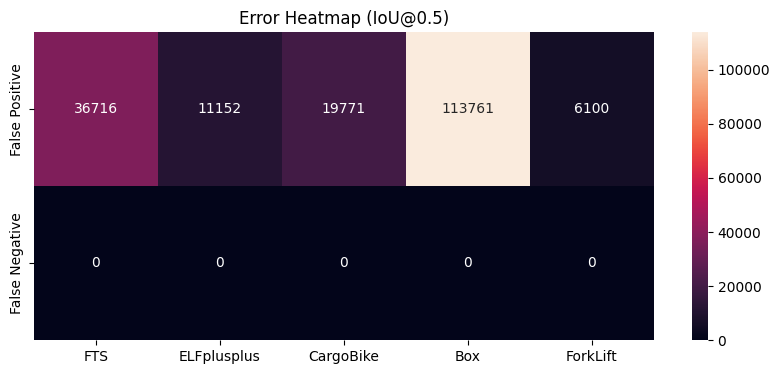

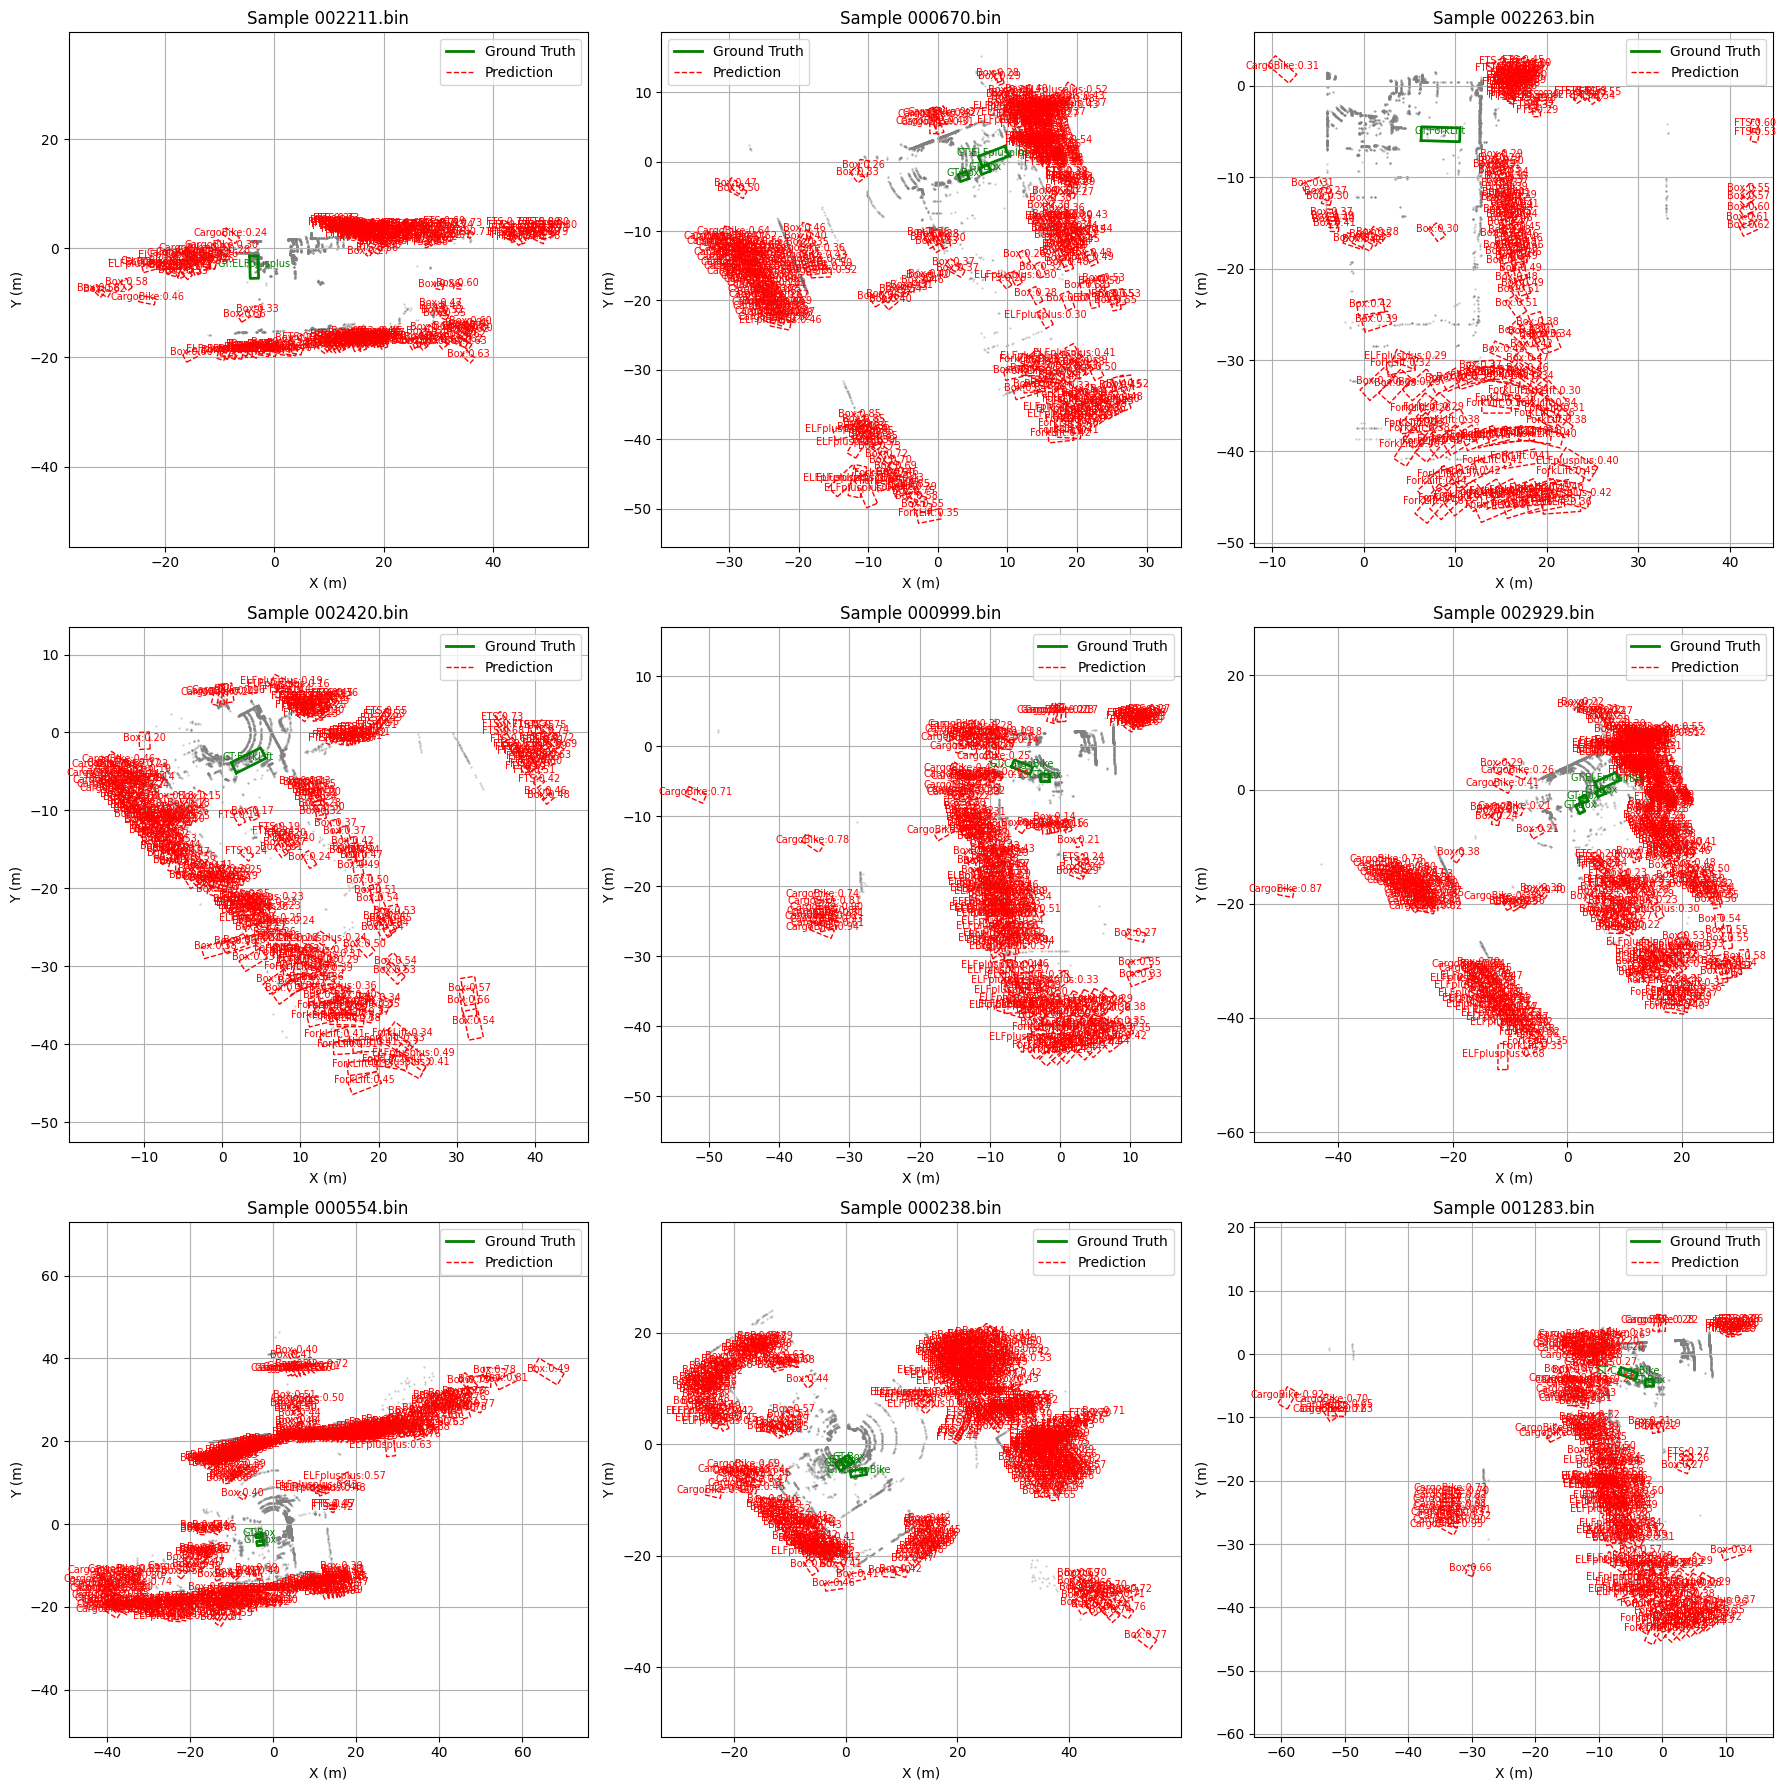


 Evaluation report saved to /kaggle/working/det_point_yolo/eval_report.json

--- Final Results Dictionary ---
{'FTS': {'mAP@0.5': 0.0, 'mAP@[0.5:0.95]': 0.0, 'GTs': 101, 'FPs_0.5': 36716, 'FNs_0.5': 0}, 'ELFplusplus': {'mAP@0.5': 0.0, 'mAP@[0.5:0.95]': 0.0, 'GTs': 224, 'FPs_0.5': 11152, 'FNs_0.5': 0}, 'CargoBike': {'mAP@0.5': 0.0, 'mAP@[0.5:0.95]': 0.0, 'GTs': 259, 'FPs_0.5': 19771, 'FNs_0.5': 0}, 'Box': {'mAP@0.5': 0.0, 'mAP@[0.5:0.95]': 0.0, 'GTs': 609, 'FPs_0.5': 113761, 'FNs_0.5': 0}, 'ForkLift': {'mAP@0.5': 0.0, 'mAP@[0.5:0.95]': 0.0, 'GTs': 102, 'FPs_0.5': 6100, 'FNs_0.5': 0}, 'mAP@0.5': 0.0, 'mAP@[0.5:0.95]': 0.0, 'errors': {'Center L2 (m)': 0, 'Size MAE (m)': 0, 'Yaw error (deg)': 0, 'AABB IoU (BEV)': 0, 'Oriented IoU (BEV)': 0, 'Positives': 0, 'Class Acc (positives only)': 0.0}}


In [2]:
import os, math, random, time, warnings
from collections import defaultdict
from pathlib import Path
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import json
warnings.filterwarnings("ignore")
from thop import profile
from sklearn.metrics import precision_recall_curve, average_precision_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# -----------------------------
# Config
# -----------------------------
class CFG:
    BASE_PATH = "/kaggle/input/3dlidar"
    BIN_DIR    = "bin"
    LABEL_DIR = "label"
    CLASSES    = ['FTS', 'ELFplusplus', 'CargoBike', 'Box', 'ForkLift']
    NUM_POINTS = 4096
    SEED = 42

    # Detection
    FEAT_DIM = 128
    DET_SAVE_DIR = "/kaggle/working/det_point_yolo"
    DET_MODEL_PATH = "/kaggle/input/det-checkpoints-epoch50/det_point_yolo/best_detector.pth"
    DET_BATCH_SIZE = 32
    # Eval/Training
    FP16 = torch.cuda.is_available()
    EVAL_CONF_THR = 0.10
    EVAL_NMS_THR = 0.45
    EVAL_IOU_THRESHOLDS = np.linspace(0.5, 0.95, 10)

random.seed(CFG.SEED); np.random.seed(CFG.SEED); torch.manual_seed(CFG.SEED)
NUM_CLASSES = len(CFG.CLASSES)

"""# Helpers"""

# -----------------------------
# Geometry helpers
# -----------------------------
def rotz(yaw):
    # Rotation matrix around z-axis for yaw.
    c, s = math.cos(yaw), math.sin(yaw)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]], np.float32)

def bev_poly(center, size, yaw):
    # Compute 2D polygon in BEV (Bird's Eye View) for a box given center, size, yaw.
    cx, cy = center[:2]; sx, sy = size[:2]
    pts = np.array([[-sx/2,-sy/2],[ sx/2,-sy/2],[ sx/2, sy/2],[-sx/2, sy/2]], np.float32)
    R = np.array([[math.cos(yaw), -math.sin(yaw)],[math.sin(yaw), math.cos(yaw)]])
    return (R @ pts.T).T + np.array([cx, cy])

def poly_iou(p1, p2):
    # Compute IoU between two oriented polygons using Shapely.
    P1, P2 = Polygon(p1), Polygon(p2)
    if not P1.is_valid or not P2.is_valid: return 0.0
    inter = P1.intersection(P2).area
    union = P1.union(P2).area + 1e-6
    return float(inter / union)

def aabb_iou_bev(b1, b2):
    # Compute Axis-Aligned Bounding Box (AABB) IoU in BEV for oriented boxes by projecting rotated polygons.
    def get_aabb(poly):
        return poly[:,0].min(), poly[:,0].max(), poly[:,1].min(), poly[:,1].max()
    p1 = bev_poly(b1[:2], b1[3:5], b1[6])
    x1_min, x1_max, y1_min, y1_max = get_aabb(p1)
    p2 = bev_poly(b2[:2], b2[3:5], b2[6])
    x2_min, x2_max, y2_min, y2_max = get_aabb(p2)
    inter_x = max(0.0, min(x1_max, x2_max) - max(x1_min, x2_min))
    inter_y = max(0.0, min(y1_max, y2_max) - max(y1_min, y2_min))
    inter = inter_x * inter_y
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - inter + 1e-6
    return inter / union

def yaw_loss(pred, gt):
    # Cosine-based loss for yaw angles.
    return (1.0 - torch.cos(pred - gt)).mean()

# -----------------------------
# Dataset helpers
# -----------------------------
def load_point_cloud(bin_path):
    # Load point cloud from .bin file (x,y,z,intensity).
    arr = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return arr[:, :3].astype(np.float32)

def parse_label_file(path):
    # Parse label file into class index and box parameters.
    if not os.path.exists(path): return np.zeros((0,8), np.float32)
    out = []
    for ln in open(path).read().strip().splitlines():
        cls, x, y, z, sx, sy, sz, yaw = ln.strip().split()
        if cls not in CFG.CLASSES: continue
        out.append([CFG.CLASSES.index(cls), float(x), float(y), float(z), float(sx), float(sy), float(sz), float(yaw)])
    return np.array(out, np.float32) if out else np.zeros((0,8), np.float32)

def sample_pc(pc, n_points):
    # Sample fixed number of points with replacement if needed.
    if pc.shape[0] > n_points:
        return pc[np.random.choice(pc.shape[0], n_points, replace=False)]
    else:
        return pc[np.random.choice(pc.shape[0], n_points, replace=True)]

# -----------------------------
# Models
# -----------------------------
class PointBackbone(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, feat), nn.ReLU()
        )
        self.bn = nn.BatchNorm1d(feat)
    def forward(self, x):
        # x: (B,N,3) -> f: (B,N,feat)
        f = self.mlp(x)
        return self.bn(f.transpose(1,2)).transpose(1,2)

class YOLO3DHead(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.pred = nn.Sequential(nn.Linear(feat, feat), nn.ReLU(), nn.Linear(feat, 7 + 1 + num_classes))
    def forward(self, f): return self.pred(f)

class YOLO3D(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, feat_dim=CFG.FEAT_DIM):
        super().__init__()
        self.backbone = PointBackbone(feat_dim)
        self.head = YOLO3DHead(feat=feat_dim, num_classes=num_classes)
    def forward(self, pc):
        f = self.backbone(pc)     # (B,N,feat)
        pred = self.head(f)       # (B,N,7+1+num_classes)
        return pred

# -----------------------------
# Dataset classes
# -----------------------------
class DetDataset(Dataset):
    def __init__(self, base, idxs, augment=False):
        self.base = base
        self.bin_dir = os.path.join(base, CFG.BIN_DIR)
        self.lab_dir = os.path.join(base, CFG.LABEL_DIR)
        files = sorted([f for f in os.listdir(self.bin_dir) if f.endswith(".bin")])
        self.files = [files[i] for i in idxs]
        self.augment = augment
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        f = self.files[i]
        pc = load_point_cloud(os.path.join(self.bin_dir, f)); pc = sample_pc(pc, CFG.NUM_POINTS)
        gts = parse_label_file(os.path.join(self.lab_dir, f.replace(".bin", ".txt")))
        if self.augment:
            yaw = random.uniform(-math.pi/6, math.pi/6)
            R = rotz(yaw)
            pc = pc @ R.T  # Rotate point cloud.
            if len(gts) > 0:
                for row in gts:
                    row[1:4] = (R @ row[1:4].copy().reshape(3,1)).reshape(3,)  # Rotate GT centers.
                    row[7] += yaw  # Update GT yaw.
        return torch.from_numpy(pc).float(), torch.from_numpy(gts).float()

def collate_det(b): pcs, gts = zip(*b); return torch.stack(pcs, 0), list(gts)

# -----------------------------
# Decode + NMS
# -----------------------------
def nms(preds, iou_thr=CFG.EVAL_NMS_THR):
    # Non-Maximum Suppression using approximate AABB IoU for speed (exact poly_iou is slow with many detections).
    preds = sorted(preds, key=lambda x: x[0], reverse=True)
    keep = []
    while preds:
        keep.append(preds[0])
        new = []
        for p in preds[1:]:
            if aabb_iou_bev(keep[-1][2], p[2]) < iou_thr:
                new.append(p)
        preds = new
    return keep

# -----------------------------------------------------------------
# START OF CRITICAL FIX
# -----------------------------------------------------------------
def decode_pred(pred, pc, thr=CFG.EVAL_CONF_THR):
    """
    Decode predictions.
    
    Args:
        pred (torch.Tensor): Model output tensor (B, N, 7+1+C) on DEVICE.
        pc (torch.Tensor): Input point cloud tensor (B, N, 3) on DEVICE.
        thr (float): Confidence threshold.
        
    Returns:
        list: A batch-sized list, where each element is a list of
              decoded (conf, cls, box_np) tuples after NMS.
    """
    # pred: (B, N, 7+1+C), torch on DEVICE
    # pc: (B, N, 3), torch on DEVICE

    # --- THIS IS THE FIX ---
    # The model predicts box parameters *relative* to the input points.
    # We must add the point coordinates (pc) to the predicted center offsets (pred[..., 0:3])
    # to get the absolute box center coordinates.
    box_params = pred[..., :7]
    pred_boxes_abs = torch.clone(box_params)
    pred_boxes_abs[..., 0:3] = box_params[..., 0:3] + pc[..., 0:3]
    # --- END FIX ---
    
    obj_logit = pred[..., 7:8]  # (B, N, 1)
    conf_obj = torch.sigmoid(obj_logit)
    cls_logits = pred[..., 8:]  # (B, N, C)
    conf_cls, cls_idx = torch.softmax(cls_logits, dim=-1).max(-1, keepdim=True)  # (B, N, 1), (B, N, 1)
    conf = conf_obj * conf_cls  # (B, N, 1)
    mask = conf > thr  # (B, N, 1)

    batch_out = []
    
    # Move all necessary tensors to CPU
    pred_boxes_abs = pred_boxes_abs.cpu()
    conf = conf.cpu()
    mask = mask.cpu()
    cls_idx = cls_idx.cpu()
    
    for b in range(pred.shape[0]):
        mb = mask[b].squeeze(-1)  # (N,)
        if not mb.any():
            batch_out.append([])
            continue
            
        # Select predictions using the mask
        box_b = pred_boxes_abs[b, mb, :]  # (M, 7) <- Using corrected boxes
        conf_b = conf[b, mb].squeeze(-1)  # (M,)
        cls_b = cls_idx[b, mb].squeeze(-1)  # (M,)
        
        # Normalize yaw
        box_b[:, 6] = torch.atan2(torch.sin(box_b[:, 6]), torch.cos(box_b[:, 6]))
        
        # Convert to list of (conf, cls, box_np)
        dets = [(conf_b[i].item(), cls_b[i].item(), box_b[i].numpy()) for i in range(box_b.shape[0])]
        
        # Limit max pre-NMS detections to prevent slow NMS
        if len(dets) > 1000:
            dets = sorted(dets, key=lambda x: x[0], reverse=True)[:1000]
            
        dets = nms(dets, CFG.EVAL_NMS_THR)
        batch_out.append(dets)
        
    return batch_out
# -----------------------------------------------------------------
# END OF CRITICAL FIX
# -----------------------------------------------------------------


# -----------------------------
# APCalculator (Detailed metrics)
# -----------------------------
class APCalculator:
    def __init__(self, num_classes, iou_thresholds):
        self.num_classes = num_classes
        self.iou_thresholds = iou_thresholds
        self.reset()
        
    def reset(self):
        self.scores = {c: {i: [] for i in self.iou_thresholds} for c in range(self.num_classes)}
        self.gt_counts = defaultdict(int)
        self.errors = {"center_l2": [], "size_mae": [], "yaw_err": [], "aabb_iou": [], "oriented_iou": []}
        self.fp_counts = defaultdict(int)
        self.fn_counts = defaultdict(int)
        self.tp_cls = 0
        self.n_pos = 0
        
    def _log_errors(self, pred_box, gt_box):
        # Log geometric errors for true positives at IoU=0.5.
        self.errors["center_l2"].append(np.linalg.norm(pred_box[:3] - gt_box[:3]))
        self.errors["size_mae"].append(np.mean(np.abs(pred_box[3:6] - gt_box[3:6])))
        yaw_err = abs(pred_box[6] - gt_box[6]); yaw_err = min(yaw_err, 2*math.pi - yaw_err)
        self.errors["yaw_err"].append(np.rad2deg(yaw_err))
        self.errors["aabb_iou"].append(aabb_iou_bev(pred_box, gt_box))
        p1 = bev_poly(pred_box[:2], pred_box[3:5], pred_box[6])
        p2 = bev_poly(gt_box[:2], gt_box[3:5], gt_box[6])
        self.errors["oriented_iou"].append(poly_iou(p1, p2))
        
    def add_batch(self, preds_batch, gts_batch):
        for b in range(len(gts_batch)):
            preds = preds_batch[b]
            gts_raw = gts_batch[b].cpu().numpy()
            gts = []
            for g in gts_raw:
                cls_gt = int(g[0])
                box_gt = g[1:8]
                gts.append((cls_gt, box_gt))
                self.gt_counts[cls_gt] += 1
                
            for iou_thr in self.iou_thresholds:
                gt_matched = {c: [False] * len(gts) for c in range(self.num_classes)}
                # Sort preds by confidence for correct mAP calculation
                preds_sorted = sorted(preds, key=lambda x: x[0], reverse=True)
                
                for conf, cls_pred, box_pred in preds_sorted:
                    ious = []
                    gt_indices = []
                    for k, (cls_gt, box_gt) in enumerate(gts):
                        if cls_gt != cls_pred: continue
                        iou = poly_iou(bev_poly(box_pred[:2], box_pred[3:5], box_pred[6]), bev_poly(box_gt[:2], box_gt[3:5], box_gt[6]))
                        ious.append(iou)
                        gt_indices.append(k)
                        
                    if not ious:
                        self.scores[cls_pred][iou_thr].append((conf, 0))
                        if iou_thr == 0.5: self.fp_counts[cls_pred] += 1
                        continue
                        
                    best_iou = max(ious); best_gt_idx = gt_indices[ious.index(best_iou)]
                    
                    if best_iou >= iou_thr and not gt_matched[cls_pred][best_gt_idx]:
                        self.scores[cls_pred][iou_thr].append((conf, 1))
                        gt_matched[cls_pred][best_gt_idx] = True
                        if iou_thr == 0.5:
                            self._log_errors(box_pred, gts[best_gt_idx][1])
                            self.n_pos += 1
                            if cls_pred == gts[best_gt_idx][0]:
                                self.tp_cls += 1
                    else:
                        self.scores[cls_pred][iou_thr].append((conf, 0))
                        if iou_thr == 0.5 and best_iou < iou_thr:
                           self.fp_counts[cls_pred] += 1
                           
            if iou_thr == 0.5:
                for k, (cls_gt, _) in enumerate(gts):
                    if not gt_matched[cls_gt][k]:
                        self.fn_counts[cls_gt] += 1
                        
    def compute_ap(self, scores_labels, num_gts):
        if num_gts == 0 or not scores_labels: return 0.0
        scores_labels = sorted(scores_labels, key=lambda x: x[0], reverse=True)
        
        y_true = np.array([label for _, label in scores_labels])
        y_scores = np.array([score for score, _ in scores_labels])
        
        if len(np.unique(y_true)) <= 1:
             # Handle case where there are no positives or no negatives
             return average_precision_score(y_true, y_scores) if y_true.sum() > 0 else 0.0
        
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        
        # Use average_precision_score for a more standard mAP calculation
        return average_precision_score(y_true, y_scores)

    def compute_metrics(self):
        results = {}
        all_aps_50 = []
        all_aps_50_95 = []
        
        for c in range(self.num_classes):
            num_gts = self.gt_counts[c]
            ap_50 = self.compute_ap(self.scores[c][0.5], num_gts)
            all_aps_50.append(ap_50)
            
            aps_c = [self.compute_ap(self.scores[c][iou_thr], num_gts) for iou_thr in self.iou_thresholds]
            ap_50_95 = np.mean(aps_c)
            all_aps_50_95.append(ap_50_95)
            
            results[CFG.CLASSES[c]] = {
                "mAP@0.5": ap_50,
                "mAP@[0.5:0.95]": ap_50_95,
                "GTs": num_gts,
                "FPs_0.5": int(self.fp_counts[c]),
                "FNs_0.5": int(self.fn_counts[c]),
            }
            
        results["mAP@0.5"] = np.mean(all_aps_50) if all_aps_50 else 0.0
        results["mAP@[0.5:0.95]"] = np.mean(all_aps_50_95) if all_aps_50_95 else 0.0
        
        results["errors"] = {
            "Center L2 (m)": np.mean(self.errors["center_l2"]) if self.errors["center_l2"] else 0,
            "Size MAE (m)": np.mean(self.errors["size_mae"]) if self.errors["size_mae"] else 0,
            "Yaw error (deg)": np.mean(self.errors["yaw_err"]) if self.errors["yaw_err"] else 0,
            "AABB IoU (BEV)": np.mean(self.errors["aabb_iou"]) if self.errors["aabb_iou"] else 0,
            "Oriented IoU (BEV)": np.mean(self.errors["oriented_iou"]) if self.errors["oriented_iou"] else 0,
            "Positives": len(self.errors["center_l2"]),
            "Class Acc (positives only)": self.tp_cls / max(1, self.n_pos)
        }
        return results

    def get_pr_data(self):
        pr_data = {}
        for c in range(self.num_classes):
            num_gts = self.gt_counts[c]
            scores_labels = self.scores[c][0.5]
            if num_gts == 0 or not scores_labels:
                pr_data[c] = (np.array([]), np.array([]), 0.0)
                continue
                
            scores, labels = zip(*sorted(scores_labels, key=lambda x: x[0], reverse=True))
            y_true = np.array(labels)
            y_scores = np.array(scores)
            
            if len(np.unique(y_true)) <= 1:
                ap = average_precision_score(y_true, y_scores) if y_true.sum() > 0 else 0.0
                precision, recall, _ = precision_recall_curve(y_true, y_scores)
            else:
                precision, recall, _ = precision_recall_curve(y_true, y_scores)
                ap = average_precision_score(y_true, y_scores)
                
            pr_data[c] = (precision, recall, ap)
        return pr_data

# -----------------------------
# Visualization helpers
# -----------------------------
def plot_pr_curves(pr_data, save_path):
    plt.figure(figsize=(10,8))
    for c, (precision, recall, ap) in pr_data.items():
        if len(recall) > 0:
            plt.plot(recall, precision, label=f"{CFG.CLASSES[c]} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (IoU@0.5)")
    plt.legend(); plt.grid(True)
    plt.savefig(save_path); plt.show()

def plot_error_heatmap(results, save_path):
    fp_matrix = [results[CFG.CLASSES[c]]["FPs_0.5"] for c in range(NUM_CLASSES)]
    fn_matrix = [results[CFG.CLASSES[c]]["FNs_0.5"] for c in range(NUM_CLASSES)]
    data = np.array([fp_matrix, fn_matrix])
    plt.figure(figsize=(10,4))
    sns.heatmap(data, annot=True, fmt="d", xticklabels=CFG.CLASSES, yticklabels=["False Positive", "False Negative"])
    plt.title("Error Heatmap (IoU@0.5)")
    plt.savefig(save_path); plt.show()

def draw_bev_grid(ax, pc, gts, preds, title):
    ax.scatter(pc[:, 0], pc[:, 1], s=0.2, c='gray', alpha=0.5)
    for cls_gt, box_gt in gts:
        poly = bev_poly(box_gt[:2], box_gt[3:5], box_gt[6])
        poly = np.vstack([poly, poly[0]])
        ax.plot(poly[:, 0], poly[:, 1], 'g-', lw=2, label="Ground Truth")
    for conf, cls_pred, box_pred in preds:
        poly = bev_poly(box_pred[:2], box_pred[3:5], box_pred[6])
        poly = np.vstack([poly, poly[0]])
        ax.plot(poly[:, 0], poly[:, 1], 'r--', lw=1, label="Prediction")
        ax.text(box_pred[0], box_pred[1], f"{CFG.CLASSES[int(cls_pred)]}:{conf:.2f}", color='red', fontsize=7, ha='center')
    
    # Add GT labels (can be crowded, but useful)
    for cls_gt, box_gt in gts:
        ax.text(box_gt[0], box_gt[1], f"GT:{CFG.CLASSES[int(cls_gt)]}", color='green', fontsize=7, ha='center')

    # Handle legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        ax.legend(by_label.values(), by_label.keys())
        
    ax.set_title(title); ax.set_xlabel("X (m)"); ax.set_ylabel("Y (m)")
    ax.axis('equal'); ax.grid(True)

def plot_qualitative_grid(model, dataset, save_path, n_show=9):
    model.eval()
    fig, axes = plt.subplots(3, 3, figsize=(18, 18))
    axes = axes.flatten()
    with torch.no_grad():
        for j in range(min(n_show, len(dataset))):
            pc, gt_tensor = dataset[j]
            pc_in = pc.unsqueeze(0).to(DEVICE)
            out = model(pc_in)
            
            # --- FIX ---
            # Pass pc_in to decode_pred
            preds = decode_pred(out, pc_in, thr=CFG.EVAL_CONF_THR)[0]
            # --- END FIX ---
            
            gts = [(int(gt_tensor[k,0].item()), gt_tensor[k,1:8].numpy()) for k in range(gt_tensor.shape[0])] if gt_tensor.numel()>0 else []
            draw_bev_grid(axes[j], pc.numpy(), gts, preds, f"Sample {dataset.files[j]}")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

"""# Evaluate & Visualize"""

# -----------------------------
# Serialization helper
# -----------------------------
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    elif isinstance(obj, np.float32) or isinstance(obj, np.float64):
        return float(obj)
    elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# -----------------------------
# Evaluate & Visualize
# -----------------------------
def evaluate_and_visualize(det_ckpt_path=None, show_plots=True):
    os.makedirs(CFG.DET_SAVE_DIR, exist_ok=True)
    
    # prepare val loader
    base = CFG.BASE_PATH
    if not os.path.exists(os.path.join(base, CFG.BIN_DIR)):
        print(f"Error: Base path not found or bin directory missing: {os.path.join(base, CFG.BIN_DIR)}")
        return {}
        
    files = sorted([f for f in os.listdir(os.path.join(base, CFG.BIN_DIR)) if f.endswith(".bin")])
    if not files:
        print(f"Error: No .bin files found in {os.path.join(base, CFG.BIN_DIR)}")
        return {}
        
    idxs = np.arange(len(files)); np.random.shuffle(idxs)
    n_val = int(0.2 * len(files))
    val_idx = idxs[:n_val]
    val_ds = DetDataset(base, val_idx, augment=False)
    val_dl = DataLoader(val_ds, batch_size=CFG.DET_BATCH_SIZE, shuffle=False, collate_fn=collate_det, num_workers=2)

    # load model
    model = YOLO3D(num_classes=NUM_CLASSES, feat_dim=CFG.FEAT_DIM).to(DEVICE)
    ckpt_path = det_ckpt_path or CFG.DET_MODEL_PATH
    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location=DEVICE)
        print(f"[EVAL] Loaded detector checkpoint from {ckpt_path} (epoch={ckpt.get('epoch','?')})")
        try:
            state_dict = ckpt["model_state_dict"]
        except KeyError:
            state_dict = ckpt # Assume it's just the state_dict
            
        # Handle potential DataParallel prefix
        state_dict_clean = {k.replace("module.", ""): v for k, v in state_dict.items()}
        
        if isinstance(model, nn.DataParallel):
             model.module.load_state_dict(state_dict_clean, strict=False)
        else:
             model.load_state_dict(state_dict_clean, strict=False)
    else:
        print(f"[EVAL] No detector checkpoint found at {ckpt_path}. Cannot evaluate.")
        return {}
    model.eval()

    # compute params, gmacs
    params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
    gmacs = None
    try:
        if profile is not None:
            dummy_input = torch.randn(1, CFG.NUM_POINTS, 3).to(DEVICE)
            gmacs, _ = profile(model, inputs=(dummy_input,), verbose=False)
            gmacs = gmacs / 1e9
    except Exception as e:
        print("[EVAL] thop.profile failed:", e)

    # measure FPS (more reliable measurement)
    n_frames = 0
    n_warmup = 10
    with torch.no_grad():
        for i, (pc, _) in enumerate(val_dl):
            if i < n_warmup: continue # Warmup
            if i == n_warmup: start = time.time() # Start timer after warmup
            pc = pc.to(DEVICE)
            _ = model(pc)
            n_frames += pc.shape[0]
            if n_frames > 500: # Measure over a reasonable number of frames
                break
    elapsed = time.time() - start
    fps = n_frames / elapsed if elapsed > 0 else 0.0


    # full evaluation with APCalculator
    calculator = APCalculator(NUM_CLASSES, CFG.EVAL_IOU_THRESHOLDS)
    with torch.no_grad():
        pbar = tqdm(total=len(val_dl), desc="[Full Eval]")
        for pc, gt_list in val_dl:
            pc = pc.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=CFG.FP16):
                out = model(pc)
                
            # --- FIX ---
            # Pass pc to decode_pred
            preds = decode_pred(out, pc, thr=CFG.EVAL_CONF_THR)
            # --- END FIX ---
            
            calculator.add_batch(preds, gt_list)
            pbar.update(1)
        pbar.close()

    results = calculator.compute_metrics()

    # print summary
    print("\n" + "="*30)
    print("  EVALUATION SUMMARY (FIXED)")
    print("="*30)
    print(f"  [Efficiency]")
    print(f"    Params (M): {params:.2f}")
    print(f"    GMACs:      {gmacs if gmacs is not None else 'N/A'}")
    print(f"    FPS:        {fps:.2f}")
    print(f"\n  [Geometric Errors (Tuned @ 0.5 IoU)]")
    print(f"    Samples (val):       {len(val_ds)}")
    print(f"    Positives (with GT): {results['errors']['Positives']}")
    print(f"    Class Acc (positives only): {results['errors']['Class Acc (positives only)']:.3f}")
    print(f"    Center L2 (m):   {results['errors']['Center L2 (m)']:.3f}")
    print(f"    Size MAE (m):    {results['errors']['Size MAE (m)']:.3f}")
    print(f"    Yaw error (deg): {results['errors']['Yaw error (deg)']:.2f}")
    print(f"    AABB IoU (BEV):    {results['errors']['AABB IoU (BEV)']:.3f}")
    print(f"    Oriented IoU (BEV): {results['errors']['Oriented IoU (BEV)']:.3f}")
    print(f"\n  [mAP Metrics]")
    print(f"    {'TOTAL':<12}: mAP@0.5={results['mAP@0.5']:.3f}  mAP@[.5:.95]={results['mAP@[0.5:0.95]']:.3f}")
    print("-" * 30)
    for c in range(NUM_CLASSES):
        cls_name = CFG.CLASSES[c]
        r = results[cls_name]
        print(f"    {cls_name:<12}: mAP@0.5={r['mAP@0.5']:.3f}  GTs={r['GTs']}  FPs={r['FPs_0.5']}  FNs={r['FNs_0.5']}")

    if not show_plots:
        print("Skipping plot generation.")
        return results

    # PR curves
    pr_data = calculator.get_pr_data()
    pr_path = os.path.join(CFG.DET_SAVE_DIR, "pr_curves.png")
    plot_pr_curves(pr_data, pr_path)

    # error heatmap
    heat_path = os.path.join(CFG.DET_SAVE_DIR, "error_heatmap.png")
    plot_error_heatmap(results, heat_path)

    # qualitative grid (use val dataset)
    qual_path = os.path.join(CFG.DET_SAVE_DIR, "qualitative_grid.png")
    plot_qualitative_grid(model, val_ds, qual_path, n_show=9)

    # save evaluation report json
    out_report = convert_to_serializable({
        "Params_M": float(params),
        "GMACs": float(gmacs) if gmacs is not None else None,
        "FPS": float(fps),
        "mAP@0.5": results.get("mAP@0.5", None),
        "mAP@[0.5:0.95]": results.get("mAP@[0.5:0.95]", None),
        "mAP_per_class": {k: v["mAP@0.5"] for k,v in results.items() if k in CFG.CLASSES},
        "Errors": results["errors"],
        "PerClassDetails": {k:v for k,v in results.items() if k in CFG.CLASSES},
        "Frames": len(val_ds)
    })
    with open(os.path.join(CFG.DET_SAVE_DIR, "eval_report.json"), "w") as f:
        json.dump(out_report, f, indent=2)
    print(f"\n Evaluation report saved to {CFG.DET_SAVE_DIR}/eval_report.json")

    return results

# Execute the corrected evaluation
if __name__ == "__main__":
    # This check is often good practice for scripts
    # In a notebook, the last line is sufficient
    results = evaluate_and_visualize()
    print("\n--- Final Results Dictionary ---")
    print(results)